# INF8460 - TP3 
# Word2vec et regroupement non supervisé (Clustering)

# 0. Pré-traitement

In [1]:
PATH = '/content/'

In [2]:
from sklearn.metrics import classification_report
import pandas as pd
import nltk
import numpy as np
from math import ceil
from torch.utils.data import DataLoader, Dataset

In [3]:
train = pd.read_csv(PATH + "train.csv")
test = pd.read_csv(PATH + "test.csv")
train

,category,headline
0,BUSINESS,MasterCard Wants You To Pay For Stuff With Sel...
1,BUSINESS,A Father's Day Gift To Our Daughters -- Making...
2,COMEDY,Hasty Pudding -
3,BUSINESS,What's Musk's 'Missing Piece?' Tesla Insider S...
4,COMEDY,You Can't Argue About The Female Cast Of This ...
...,...,...
11611,BUSINESS,New Orleans Restaurant Under Fire For Racist R...
11612,BUSINESS,"Remy Martin's 2,500 Euro Louis XIII Cognac In ..."
11613,COMEDY,The Funniest Someecards Of The Week (PICTURES)...
11614,CRIME,Mobster 'Whitey' Bulger Says His Life Was 'Was...


In [4]:
train["category"].value_counts()

BUSINESS    4704
COMEDY      4163
CRIME       2749
Name: category, dtype: int64

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re

nltk.download('stopwords')
nltk.download('punkt')

stopwords = stopwords.words('english')
stemmer = nltk.stem.porter.PorterStemmer()


def preprocess(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"[^A-Za-z0-9]", " ", sentence)
    tokens = word_tokenize(sentence)
    tokens = [token for token in tokens if token not in stopwords]
    
    tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
train["tokens"] = train["headline"].apply(preprocess)
test["tokens"] = test["headline"].apply(preprocess)
train

,category,headline,tokens
0,BUSINESS,MasterCard Wants You To Pay For Stuff With Sel...,"[mastercard, want, pay, stuff, selfi, compani,..."
1,BUSINESS,A Father's Day Gift To Our Daughters -- Making...,"[father, day, gift, daughter, make, connect, d..."
2,COMEDY,Hasty Pudding -,"[hasti, pud]"
3,BUSINESS,What's Musk's 'Missing Piece?' Tesla Insider S...,"[musk, miss, piec, tesla, insid, share, insigh..."
4,COMEDY,You Can't Argue About The Female Cast Of This ...,"[argu, femal, cast, trump, ghostbust, parodi, ..."
...,...,...,...
11611,BUSINESS,New Orleans Restaurant Under Fire For Racist R...,"[new, orlean, restaur, fire, racist, receipt]"
11612,BUSINESS,"Remy Martin's 2,500 Euro Louis XIII Cognac In ...","[remi, martin, 2, 500, euro, loui, xiii, cogna..."
11613,COMEDY,The Funniest Someecards Of The Week (PICTURES)...,"[funniest, someecard, week, pictur, tax, day, ..."
11614,CRIME,Mobster 'Whitey' Bulger Says His Life Was 'Was...,"[mobster, whitey, bulger, say, life, wast, let..."


# 1. Implémentation d'un modèle Skipgram avec Pytorch



<img src="https://aegis4048.github.io/jupyter_images/skip-gram-paper.png" width=300 height=300 />

Dans cet exercice, vous allez implémenter un modèle Skipgram afin d'obtenir une représentation vectorielle de chaque mot, aussi appelé word embedding en anglais. 





### 1.1 Transformez chaque liste de jetons de la colonne "headline" en une séquence d'indices et stockez le résultat dans une nouvelle colonne "sequence". 

Pour transformer une phrase en séquence, il faut remplacer les jetons par leur indice respectif dans le vocabulaire.

Exemple:

entrée:   
```
# indices :  0        1      2          3        4
vocab =     ["Alice", "Bob", "Charlie", "likes", "cats"]

phrase_1 = ["Alice", "likes", "Bob"]
phrase_2 = ["Charlie", "likes", "cats"]
```

sortie:   

```
sequence_1 = [0, 3, 1]
sequence_2 = [2, 3, 4]
```
 



In [7]:
def build_vocab(docs):
    vocab = []
    for doc in docs:
        for token in doc:
            if token not in vocab:
                vocab.append(token)

    return vocab

def tokens_sequencing(vocab, docs):
    sequenceColumn = []
    for doc in docs:
        sequence = []
        for token in doc:
            if token in vocab:
                sequence.append(vocab.index(token))
        sequenceColumn.append(sequence)
    
    return sequenceColumn

vocab = build_vocab(train["tokens"])
train["sequence"] = tokens_sequencing(vocab, train["tokens"])
test["sequence"] = tokens_sequencing(vocab, test["tokens"])



In [8]:
train[:10]

,category,headline,tokens,sequence
0,BUSINESS,MasterCard Wants You To Pay For Stuff With Sel...,"[mastercard, want, pay, stuff, selfi, compani,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 4, ..."
1,BUSINESS,A Father's Day Gift To Our Daughters -- Making...,"[father, day, gift, daughter, make, connect, d...","[16, 17, 18, 19, 20, 21, 22, 23, 24, 19, 25, 2..."
2,COMEDY,Hasty Pudding -,"[hasti, pud]","[28, 29]"
3,BUSINESS,What's Musk's 'Missing Piece?' Tesla Insider S...,"[musk, miss, piec, tesla, insid, share, insigh...","[30, 31, 32, 33, 34, 35, 36, 37, 38, 30, 39, 4..."
4,COMEDY,You Can't Argue About The Female Cast Of This ...,"[argu, femal, cast, trump, ghostbust, parodi, ...","[50, 51, 52, 53, 54, 55, 56, 53]"
5,BUSINESS,Wealthy Greek Tax Dodgers Escaping Crackdown: ...,"[wealthi, greek, tax, dodger, escap, crackdown...","[57, 58, 59, 60, 61, 62, 63, 64, 65, 59, 66, 6..."
6,BUSINESS,"Women in Business: Kristin Lemkau, Chief Marke...","[women, busi, kristin, lemkau, chief, market, ...","[75, 46, 76, 77, 78, 79, 80, 81, 82, 83, 84, 8..."
7,BUSINESS,Shane Smith & Eddy Moretti Talk Youth Unemploy...,"[shane, smith, eddi, moretti, talk, youth, une...","[98, 99, 100, 101, 102, 103, 104, 105, 106, 10..."
8,CRIME,College Football Player Used Drugs Before Texa...,"[colleg, footbal, player, use, drug, texa, pol...","[118, 119, 120, 12, 121, 122, 123, 124, 125, 1..."
9,CRIME,"Man Fined $100,000 After Shining Laser At Ferr...","[man, fine, 100, 000, shine, laser, ferri, inj...","[128, 129, 130, 131, 132, 133, 134, 135, 136, ..."


### 1.2 Complétez la classe SkipGramDataLoader qui génère des exemples d'entraînement.

L'objectif du skipgram est de prendre en entrée un mot quelconque et de prédire un mot faisant partie de son entourage (l'entourage étant déterminé par la taille de la fenêtre (window size)). Sois le jeton $w(t)$ à la position $t$ avec une fenêtre de mots de taille 5 (incluant le mot cible), le modèle doit prédire les jetons $w(t-2)$, $w(t-1)$, $w(t+1)$, $w(t+2)$.
Ici votre skip-gram a une taille k de 2.

Pour ce faire nous créons des paires de mots arrangées de la manière suivante: jeton d'entrée et jeton prédit. 

Par exemple, si nous avons les phrases:

>Alice likes Bob but not cats. 

>Charlie likes cats.

Nous créons l'ensemble d'entrainement:


| Jeton d'entrée | jeton prédit |
|------|------|
| Alice | likes | 
| Alice | Bob |
| likes | Alice |
| likes | Bob |
| ... | ... |
| cats | Charlie |
| cats | likes |


Implémentez les fonctions suivantes:

1. \_\_init__ 

      Complétez le constructeur et construisez l'ensemble d'entrainement comme indiqué plus haut
      
      
      

2. \_\_getitem__(self, idx)

      Cette fonction retourne l'exemple à l'indice voulu idx provenant de l'ensemble d'entrainement. Le format voulu est sous la forme: tuple(jeton d'entrée, jeton prédit)
      
      


3. \_\_len__(self)

     Cette fonction retourne la taille de l'ensemble d'entrainement

In [9]:
class SkipGramDataset(Dataset):
    def __init__(self, sequences, window_size=5):
        self.sequences = sequences
        self.window_size = window_size

        self.train_data = []
        for doc in sequences:
            for idx, token in enumerate(doc):
                for i in range(int(-window_size/2), int((window_size/2)+1)):
                    if idx+i < len(doc) and idx+i >= 0 and idx+i != idx:
                        self.train_data.append((token, doc[idx+i]))
                  
                
    def __getitem__(self, idx):
        return self.train_data[idx]
        

    def __len__(self):
        return len(self.train_data)


In [10]:
### Ces tests doivent réussir

exemples = [[0, 1, 2, 3, 4], [10, 11, 12, 13, 14]]


test_skipgram_data = SkipGramDataset(exemples, window_size=5)
assert test_skipgram_data[0] == (0,1)
assert test_skipgram_data[1] == (0,2)
assert test_skipgram_data[2] == (1,0)
assert test_skipgram_data[3] == (1,2)
assert test_skipgram_data[4] == (1,3)
assert test_skipgram_data[13] == (4,3)
assert test_skipgram_data[20] == (12,11)


### 1.3 Implémentez maintenant l'architecture du Skipgram



On vous demande d'implémenter l'architecture du Skipgram avec pytorch. Il vous est aussi demandé de faire l'optimisation par batch avec une grandeur de batch variable (déterminé par len(batch_inputs)). 

Ci bas se trouve l'architecture générale du Skipgram, avec un exemple qui illustre les calculs lors de l'entraînement.


Visualisation des matrices de poids: 
<img src="https://iksinc.files.wordpress.com/2015/04/screen-shot-2015-04-10-at-4-16-00-pm.png" style="margin-left:-10px" title="Architecture générale" width=800 height=300 />

Visualisation d'un exemple d'entraînement. 
Dans cet exemple, le jeton passé en entrée dans le skipgram est "likes":
<img src="https://i.postimg.cc/CxDmp3BK/test.png" style="margin-left:-60px" width=1000 height=0 />

Exemple d'un batch:

| Jeton d'entrée | jeton prédit |
|------|------|
| Alice | likes | 
| cats | Charlie |
| likes | Bob |

```
# indices :  0        1      2          3        4
vocab =     ["Alice", "Bob", "Charlie", "likes", "cats"]
```

```
#              Alice, cats, likes
batch_inputs = [0, 4, 3]

#              likes, Charlie, Bob
batch_labels = [3, 2, 1]

```

Sois V la taille du vocabulaire et N la taille d'embedding. L'architecture comprend 2 matrices de poids:

1. La matrice d'encodage $W_i$ de taille $VxN$. Cette matrice est une 'look up table' c'est à dire qu'elle prend en entrée un index dans le vocabulaire et retourne la ligne de la matrice correspondant à cet index. (Correspond à torch.nn.Embedding)

2. La matrice de sortie $W_o$ de taille $NxV$. Cette matrice est multipliée par le vecteur $h$ provenant de l'étape précédente pour obtenir le vecteur de sortie $y$. (Correspond à torch.nn.Linear)

**Les fonctions et classes de pytorch dont vous pouvez vous servir sont: torch.nn.Embedding, torch.nn.Linear et torch.nn.log_softmax. Fiez vous à la documentation de [Pytorch](https://pytorch.org/docs/stable/). Voir aussi le tutoriel 3 pour plus d'aide.**


Implémentez les fonctions suivantes de la classe SkipGramSoftMax:
    
1. \_\_init__ 

        Complétez le constructeur en initialisant aléatoirement les matrices de poids.
      
      
      

2. forward(self, batch_inputs: List[int])
      
      param: batch_inputs: List[int]
      
      return: valeurs softmax avec shape=(len(batch_inputs), len(vocab))
      
        forward est la méthode de la propagation vers l'avant, qui vous permet de retourner une distribution de probabilité sur le vocabulaire.
        
        Cette fonction prends en entrée un batch de séquences,
        puis calcule et retourne les valeurs log_softmax correspondantes.
      
      


3. embed(self, indices)
    
    param: indices: List[int]
    
    return: représentations vectorielles avec shape=(len(indices), embed_size)
          
       Cette fonction prend en entrée un batch d'indices, et retourne les représentations vectorielles (projection/plongements lexicaux). Ceux-ci sont obtenus en calculant le vecteur h dans la figure ci-dessus. 

In [11]:
import torch
import torch.nn as nn
from torch.nn import Embedding, Linear, Module
from torch.nn.functional import log_softmax
from typing import List
from sklearn.preprocessing import normalize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SkipGramSoftMax(Module):
    def __init__(self, vocab, embed_size):
        super().__init__()
        self.embed_size = embed_size
        self.vocab = vocab
        self.embeddings = Embedding(len(vocab), embed_size, device=device)
        self.linear = Linear(embed_size, len(vocab), device=device)
        self.log_softmax = log_softmax
           
        
    def forward(self, batch_inputs: List[int]):
        
        embeds = self.embeddings(torch.tensor(batch_inputs))
        out = self.linear(embeds)
        out = self.log_softmax(out, dim=1)
        return out

    def embed(self, indices: List[int]):

        return self.embeddings(torch.tensor(indices))

    
    

### 1.4 Entrainez le modèle skipgram


Complétez le processus d'entraînement. Les étapes à suivre sont définies ci-bas.
**Voir le tutoriel pour plus d'aide.**

1. Initialiser les gradients à zéro 

2. Passer les batchs_inputs dans le skipgram afin d'obtenir les valeurs de sortie.

3. Passer les sorties du réseau et les labels dans la fonction de perte (loss function)

4. Calculer les valeurs de gradients avec la fonction backward() 

5. Mettre à jour les poids avec l'optimiseur. Ici nous utiliserons Adam.

In [12]:
from torch.nn import NLLLoss 
from torch.optim import Adam
from tqdm import tqdm

### Création du batch loader
skipgram_data = SkipGramDataset(train["sequence"], window_size=5)
batch_loader = DataLoader(skipgram_data, batch_size=128, shuffle=True)

### Création du modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
skipgram = SkipGramSoftMax(vocab, 100).to(device)

### Fonction permettant de calculer le loss
loss_function = NLLLoss()

### optimiseur suivant la descente de gradiant ADAM
optimizer = Adam(skipgram.parameters())

epochs = 10

for epoch in range(epochs):

    for batch_inputs, batch_labels in tqdm(batch_loader):

        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        ### Initialisation des gradients à 0
        optimizer.zero_grad()
        
        ### Calcul de la sortie du modèle
        output = skipgram.forward(batch_inputs)
        loss = loss_function(output, batch_labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} loss: {loss.item()}")

100%|██████████| 5468/5468 [00:15<00:00, 357.04it/s]


Epoch 1 loss: 7.7186808586120605


100%|██████████| 5468/5468 [00:12<00:00, 422.04it/s]


Epoch 2 loss: 7.699986934661865


100%|██████████| 5468/5468 [00:12<00:00, 426.93it/s]


Epoch 3 loss: 7.444594383239746


100%|██████████| 5468/5468 [00:12<00:00, 425.73it/s]


Epoch 4 loss: 7.388589859008789


100%|██████████| 5468/5468 [00:12<00:00, 425.18it/s]


Epoch 5 loss: 7.268803119659424


100%|██████████| 5468/5468 [00:12<00:00, 422.99it/s]


Epoch 6 loss: 7.570357322692871


100%|██████████| 5468/5468 [00:12<00:00, 423.53it/s]


Epoch 7 loss: 6.693177223205566


100%|██████████| 5468/5468 [00:12<00:00, 425.92it/s]


Epoch 8 loss: 7.174704551696777


100%|██████████| 5468/5468 [00:12<00:00, 424.81it/s]


Epoch 9 loss: 6.796041488647461


100%|██████████| 5468/5468 [00:12<00:00, 426.76it/s]

Epoch 10 loss: 6.405659198760986


# 2. Clustering K-MEANS avec représentation vectorielle de documents

Dans cet exercice, l'objectif est de regrouper d'une manière non-supervisée les documents (headline) afin de les classifier, les performances des différentes représentations illustreront l'efficacité de word2vec. 

Nous allons d'abord construire 3 représentations vectorielles différentes qui seront comparées avec l'algorithme de clustering.

### 2.1 Encodage de documents avec Tfidf + LSA

Sans faire d'optimisation de paramètres, combinez TfIdfVectorizer ainsi que TruncatedSVD (LSA) afin d'approximer les documents (la colonne "tokens") dans un espace vectoriel de même taille que les plongements de mots obtenus avec votre modèle Skip-gram.

Faites ce processus pour l'ensemble de test et d'entraînement et gardez les résultats en mémoire.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

tfidf = TfidfVectorizer(vocabulary=vocab)
tfidf_train_matrix = tfidf.fit_transform(train["tokens"].apply(lambda x: " ".join(x)).values)
tfidf_test_matrix = tfidf.transform(test["tokens"].apply(lambda x: " ".join(x)).values)
svd = TruncatedSVD(n_components=500)
svd_train_matrix = svd.fit_transform(tfidf_train_matrix)
svd_test_matrix = svd.transform(tfidf_test_matrix)

### 2.2 Encodage de documents avec votre modèle Skip-gram

Pour chaque exemple, retrouvez la représentation vectorielle de tous les jetons du document avec votre modèle Skip-gram, puis calculez leur moyenne. Vous passerez donc de plusieurs vecteurs représentants les jetons du document, à un seul vecteur, qui sera la moyenne de ces derniers.


ex:

>jetons:  "Alice"     "likes"       "Bob"

>vecteur: [0,1,2]     [1,2,3]       [2,3,4]

>vecteur moyen: [1,2,3]



Faites ce processus pour l'ensemble de test et d'entraînement et gardez les résultats en mémoire.


Utilisez la fonction 'embed' de votre modèle skipgram pour retrouver la représentation vectorielle d'un jeton.

In [14]:
vecteurs_moyens_skip_train = []
vecteurs_moyens_skip_test = []
skipgram = skipgram.to(device)
    
for doc in train["sequence"]:
    vecteurs_moyens_skip_train.append(np.mean(skipgram.embed(torch.tensor(doc, device = device)).to(device).detach().cpu().numpy(), axis=0))
    
for doc in test["sequence"]:
    if len(doc) > 0:
      vecteurs_moyens_skip_test.append(np.mean(skipgram.embed(torch.tensor(doc, device = device)).to(device).detach().cpu().numpy(), axis=0))
    else:
      vecteurs_moyens_skip_test.append(np.zeros(100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### 2.3 Encodage de documents avec les plongements word2vec pré-entrainés de Gensim

Gensim vous offre des [représentations vectorielles pré-entraînées](https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models) faciles à utiliser.  

Obtenez les vecteurs pré-entrainés intitulés 'word2vec-google-news-300'. Pour chaque exemple, retrouvez la représentation vectorielle de tous les jetons du document avec votre modèle pré-entraîné, puis calculez leur moyenne comme on fait en 2.2. Vous passerez donc de plusieurs vecteurs représentants les jetons du document, à un seul vecteur, qui sera la moyenne de ces derniers.


Faites ce processus pour l'ensemble de test et d'entraînement et gardez les résultats en mémoire.

In [15]:
import gensim.downloader

word2vec = gensim.downloader.load('word2vec-google-news-300')
vecteurs_moyens_word2vec_train = []
vecteurs_moyens_word2vec_test = []

for doc in train["tokens"]:
    doc_vect = np.zeros((len(doc), 300)) # 300 is the size of word2vec vectors
    for i, token in enumerate(doc):
        if token in word2vec:
            doc_vect[i] = word2vec[token]
        else:
            np.delete(doc_vect, i, 1)
    if len(doc_vect) == 0:
        doc_vect = np.zeros((1,300))
    vecteurs_moyens_word2vec_train.append(np.mean(doc_vect, axis=0))

for doc in test["tokens"]:
    doc_vect = np.zeros((len(doc), 300)) # 300 is the size of word2vec vectors
    for i, token in enumerate(doc):
        if token in word2vec:
            doc_vect[i] = word2vec[token]
        else:
            np.delete(doc_vect, i, 1)
    if len(doc_vect) == 0:
        doc_vect = np.zeros((1,300))
    vecteurs_moyens_word2vec_test.append(np.mean(doc_vect, axis=0))

[==================================================] 100.0% 1662.8/1662.8MB downloaded


### 2.4 Clustering avec K-Means

Complétez la fonction cluster_and_eval(X_train, y_train, test_X, test_y)

Cette fonction entraine un algorithme K-Means avec 3 clusters.

Étant donné que K-Means est un algorithme non-supervisé, les clusters ne sont pas étiquettés. Trouvez une manière d'identifier quel cluster est relié à quelle classe en utilisant la classe (y) de chaque exemple de votre ensemble d'entrainement.

Ensuite, vous devez afficher les métriques d'évaluation de votre clustering étiquetté avec classification_report de sklearn. Utilisez X_test et y_test pour cela.

In [16]:
from sklearn.cluster import KMeans

def cluster_and_eval(X_train, y_train, X_test, y_test):
    nbr_clusters = 3
    kmeans = KMeans(n_clusters=nbr_clusters, random_state=0).fit(X_train)
    y_pred = kmeans.predict(X_test)
    repart = np.bincount(y_pred)
    business_index = np.argmax(repart)
    crime_index = np.argmin(repart)
    def f(i):
      if i == business_index:
        return 0
      elif i == crime_index:
        return 2
      else:
        return 1
    
    labels = np.vectorize(f)(y_pred)
    
    print(f"classification report: {classification_report(y_test, labels)}")

    # Pour étiqueter les clusters
    clusters = [np.where(kmeans.labels_ == clus)[0] for clus in range(nbr_clusters)]
    clusters_labels = [y_train[np.where(clus)[0]] for clus in clusters]
    counts = [np.unique(clus_labels, return_counts=True)[1] for clus_labels in clusters_labels]
    for index, number in enumerate(counts):
      print("Cluster {} : il y a {} éléments de BUSINESS, COMEDY et CRIME".format(index, number))

### 2.5 Exécution de la fonction cluster_and_eval sur les 3 représentations obtenues en 2.1, 2.2 et 2.3

In [17]:
# Transformation des categories en entiers
# 0: Business
# 1: Comedy
# 2: Crime

train["label"] = train["category"].astype("category").cat.codes
test["label"] = test["category"].astype("category").cat.codes

In [18]:
cluster_and_eval(svd_train_matrix, train["label"], svd_test_matrix, test["label"])

classification report:               precision    recall  f1-score   support

           0       0.53      0.98      0.68      1232
           1       0.02      0.01      0.01      1010
           2       0.00      0.00      0.00       656

    accuracy                           0.42      2898
   macro avg       0.18      0.33      0.23      2898
weighted avg       0.23      0.42      0.30      2898

Cluster 0 : il y a [627 569 398] éléments de BUSINESS, COMEDY et CRIME
Cluster 1 : il y a [367 332 227] éléments de BUSINESS, COMEDY et CRIME
Cluster 2 : il y a [3678 3291 2126] éléments de BUSINESS, COMEDY et CRIME


In [19]:
cluster_and_eval(vecteurs_moyens_skip_train, train["label"], vecteurs_moyens_skip_test, test["label"])

classification report:               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1232
           1       0.90      0.81      0.85      1010
           2       0.91      0.86      0.88       656

    accuracy                           0.86      2898
   macro avg       0.88      0.86      0.86      2898
weighted avg       0.87      0.86      0.86      2898

Cluster 0 : il y a [1530 1418  914] éléments de BUSINESS, COMEDY et CRIME
Cluster 1 : il y a [1015  986  633] éléments de BUSINESS, COMEDY et CRIME
Cluster 2 : il y a [2059 1855 1205] éléments de BUSINESS, COMEDY et CRIME


In [20]:
cluster_and_eval(vecteurs_moyens_word2vec_train, train["label"], vecteurs_moyens_word2vec_test, test["label"])

classification report:               precision    recall  f1-score   support

           0       0.64      0.83      0.72      1232
           1       0.68      0.54      0.60      1010
           2       0.92      0.71      0.80       656

    accuracy                           0.70      2898
   macro avg       0.75      0.69      0.71      2898
weighted avg       0.72      0.70      0.70      2898

Cluster 0 : il y a [834 791 534] éléments de BUSINESS, COMEDY et CRIME
Cluster 1 : il y a [2478 2202 1448] éléments de BUSINESS, COMEDY et CRIME
Cluster 2 : il y a [1301 1230  797] éléments de BUSINESS, COMEDY et CRIME


### 2.6 Discussion

Limitez-vous à 4 lignes maximum par réponse

**2.6.1** Si vos implémentations fonctionnent, vous devriez remarquer que le Skipgram avec softmax (2.2) est le modèle obtenant les meilleurs résultats. Pourquoi selon vous, le Skipgram avec softmax(2.2) arrive à des meilleurs résultats que le skipgram avec negative sampling (2.3)? 

Le skipgram avec negative sampling est plus rapide que le skipgram avec softmax. Toutefois, le skipgram avec négative sampling se base sur une sélection aléatoire de ses échantillons négatifs. Toutes les possibilités ne sont pas explorées. Ce skipgram a donc des moins bons résultats que l'autre.


**2.6.2** Pourquoi selon vous le modèle skipgram fonctionne aussi bien dans ce contexte de clustering?





Le modèle skipgram fonctionne bien dans un contexte de clustering car il consiste à associer des probabilités concernant la proximité des mots dans une phrase. Cela permet donc de créer des groupes de mots proches et donc d'identifier des cluster. 

**2.6.3** Pour un exemple positif (batch_size=1), combien de paramètres sont mis à jour pour:



a) le skipgram avec softmax 

Le modèle skipgram apprend 2 embeddings pour chaque mot. La taille du batch est de 1. On considère donc un seul mot. Soit k le paramètre indiquant la taille de la fenêtre. Si k=2, on s'intéresse à wt-1,wt-2,wt+1 et wt+2. Les matrices des paramètres sont de tailles V*N pour le premier embedding et NxV pour le deuxième avec V la taille du vocabulaire et N la dimension de projection.Pour le premier embedding VxN paramètres sont mis à jour. Ensuite pour le deuxième embedding V*N paramètres sont mis à jour.
On a donc NxV+VxN paramètres mis à jour. 

b) BONUS: le skipgram avec negative sampling (5 negative samples):

Le modèle skipgram apprend 2 embeddings pour chaque mot. La taille du batch est de 1. On considère donc un seul mot. Soit k le paramètre indiquant la taille de la fenêtre. Si k=2, on s'intéresse à wt-1,wt-2,wt+1 et wt+2. On a kx2 exemples positifs et kx2xk exemples négatifs. k exemples négatifs pour chaque exemple positif. 
Les matrices des paramètres sont de tailles V*N pour le premier embedding et NxV pour le deuxième avec V la taille du vocabulaire et N la dimension de projection.Pour le premier embedding seuls les paramètres du mot cible sont mis à jour soit 1xN paramètres . Ensuite pour le deuxième embedding les paramètres des mots parasites sont mis à jour soit  (2xk+kx2xk)xN.
On a donc N+(2xk+kx2xk)xN paramètres mis à jour. Si on a 5 negative samples ça fait 13xN paramètres mis à jour.

# 3.Visualisation des représentations vectorielles

Ici les représentations vectorielles seront projetées dans une dimension inférieure, cela nous permet de mieux comprendre la composition des clusters créés par l'algorithme K-Means. 

Projetez les représentations de documents provenant du skipgram softmax (2.2) dans un espace 2D à l'aide de PCA. Le résultat devrait être un nuage de points ayant 3 couleurs (1 par catégorie), chaque point du nuage est un exemple et a la couleur de sa catégorie. Par exemple, si on définit la catégorie Business comme étant la catégorie avec la couleur bleue, on affiche tous les points de cette catégorie en bleu. Assurez-vous que la couleur de chaque catégorie soit bien identifiée. 

Utilisez l'ensemble d'entrainement pour faire cette visualisation.

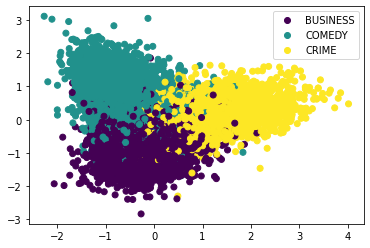

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_train_matrix = pca.fit_transform(vecteurs_moyens_skip_train)
pca_test_matrix = pca.transform(vecteurs_moyens_skip_test)

scatter=plt.scatter(pca_train_matrix[:,0], pca_train_matrix[:,1], c=train["label"])
classes= ["BUSINESS", "COMEDY", "CRIME"]
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()






